In [1]:
# Initial report setup.
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import re
from datetime import datetime
import scipy.stats as stats
from matplotlib.patches import Rectangle

# Colors for graphs
blue = (82/255, 115/255, 178/255, 0.5)
green = (96/255, 168/255, 101/255, 0.5)

yellow = (162/255, 168/255, 96/255, 0.5)
red = (168/255, 96/255, 96/255, 0.5)

# Capstone for Thinkful - Data Science Bootcamp

## Overview
In this report, we will compare serving size and sugar content between these two countries; United States and France. We will ask the following questions with follow-up questions:
 - Is there more sugar in liquid products than solid products?
 - Is everything bigger and sweeter in the US?

To answer these questions we will be using the data source [Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/data).

## Data source
The data source [Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/data) is an open and collaborative database of food products from around the world. It contains information from product labels visible on product packages. This is a data source which has been built up by volunteers from around the world.

The data source contains over 100 000 products from over 150 countries. And over 5000 individuals have contributed to it.

Among other things, it contains the following information:
 - Countries where the product is sold (`countries_en`)
 - Amount of sugar per 100g (`sugars_100g`)
 - Serving size and packaging (`serving_size`)
 
The data itself is quite noisy with a lot of missing or erronous data, this fact has to be considered in our analysis.

In [2]:
# Loading data from tab-separated file. Original data source can be downloaded here: https://www.kaggle.com/openfoodfacts/world-food-facts/data
foodfacts = pd.read_csv('en.openfoodfacts.org.products.tsv', sep="\t", low_memory=False)

# These columns which we might be interested in.
columns = [
    'caffeine_100g',
    'sugars_100g',
    'carbohydrates_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
    'fat_100g'
]


## Data transformation
Since we will compare serving size and sugar content between two countries; United States and France, we'll mainly focus on the following columns:
 - Countries where the product is sold (`countries_en`)
 - Amount of sugar per 100g (`sugars_100g`)
 - Serving size and packaging (`serving_size`)
 
To simplify analysis we'll the following transformations 
 1. Removing "extreme values"
 2. Adding features: `type` and `servingsize`
 3. Adding features: `is_fr`, `is_us`
 4. Removing unknown data

#### 1. Removing "extreme values"
To make analysis easier we'll remove extreme values from the data set. Extreme values are such values that we do not trust. It's either too large compared to rest of the dataset, or it's not logical value consindering the data.

We will be removing the following values from `sugars_100g` (and `caffeine_100g`, `carbohydrates_100g`, `fiber_100g`, `proteins_100g`, `salt_100g`, `fat_100g` as these may be interesting)
 - Top 99-percentile, removes values that are too large compared to our dataset
 - All values < 0, removes values that are not logical
 

In [3]:
# Remove extreme value, top 99% and everything below 0
for column in columns:
    foodfacts[column] = foodfacts[ foodfacts[column] < foodfacts[column].quantile(.99) ][column]
    foodfacts[column] = foodfacts[ foodfacts[column] > 0 ][column]


#### 2. Adding features: type and servingsize
To allow us to use serving size in our analysis, we need to look at column `serving_size` to determine type of product (liquid or solid) and size of packaging. Column `serving_size` typically the following format:
 - `12 g (1 PACKAGE)`
 - `15 g (15 GRM)`
 - `240 ml (8 fl oz)`
 
We will look at existence of `g` or `ml` to determine if the product is a solid or a liquid (feature `type`).
And use the first number in the string to represent numeric value of serving size (feature `servingsize`)

**Note!** This format is typical, but far from ever-present. Products which do not conform to this format, will be ignored in our analysis.

In [4]:
# Add features is_solid and is_liquid.
foodfacts['is_solid']    = foodfacts['serving_size'].apply(lambda x: False if isinstance(x, float) else ' g ' in re.findall(' g ', x) )
foodfacts['is_liquid']   = foodfacts['serving_size'].apply(lambda x: False if isinstance(x, float) else ' ml ' in re.findall(' ml ', x) )
# Add feature type, based on feature is_solid, is_liquid
# Note! There's probably a more efficient way of engineering this feature
foodfacts['packagetype'] = foodfacts.apply(lambda x: 'liquid' if x['is_liquid'] else 'solid' if x['is_solid'] else 'unknown', axis=1 )

def ext_servingsize(x):
    if isinstance(x, float):
        return x
    else:
        numbers = re.findall('\d+', x)
        if len(numbers) > 0:
            return np.int(numbers[0])
    return None

# Add feature servingsize as integer
foodfacts['servingsize'] = foodfacts['serving_size'].apply( ext_servingsize )


#### 3. Adding features: `is_fr`, `is_us`
To compare products available in France and United States, we will add the following features based on existing feature `country`:
 - `is_fr`
 - `is_us`


In [5]:
# Defining extract functions
def is_us(x):
    if isinstance(x, str):
        if 'United States' in re.findall('United States', x):
            return False
    return True

def is_fr(x):
    if isinstance(x, str):
        if 'France' in re.findall('France', x):
            return True
    return False

# Extracting the data itself
foodfacts['is_us'] = foodfacts['countries_en'].apply(is_us)
foodfacts['is_fr'] = foodfacts['countries_en'].apply(is_fr)

#### 3. Removing unknown data
For many rows we do not know the serving size or sugar content. Further, a product is not interesting for us if it's not available in the US or France. These values will be removed.

In [6]:
# Removing products not available in France or the US
foodfacts = foodfacts.loc[ (foodfacts['is_us'] == True) | (foodfacts['is_fr'] == True) ]
# Removing products where either servingsize is None or product type is unknown
foodfacts = foodfacts.loc[ (not foodfacts['servingsize'] is None) & (foodfacts['packagetype'] != 'unknown') ]
# Removing products where sugar content isn't known
#foodfacts = foodfacts.loc[ (not foodfacts['sugars_100g'] is None) ]

In [7]:
foodfacts[ ['packagetype','servingsize','sugars_100g','is_fr', 'is_us'] ].head()

,packagetype,servingsize,sugars_100g,is_fr,is_us
138,solid,48.0,NaN,True,False
175,solid,146.0,28.100,False,True
180,solid,150.0,24.700,False,True
181,solid,90.0,1.110,False,True
185,solid,280.0,0.714,False,True


In [8]:
foodfacts[ ['packagetype','servingsize','sugars_100g','is_fr', 'is_us'] ]['sugars_100g'].describe()

count    3419.000000
mean       10.534042
std        13.750038
min         0.010000
25%         1.400000
50%         4.500000
75%        14.000000
max        85.000000
Name: sugars_100g, dtype: float64

## Question 1: Is there more sugar in liquid products than solid products?
There is a common belief today that sugary drinks is a one of the primary health dangers. But does a liquid product contain more sugar than a solid product?

To answer this, we'll compare serving size per product type (solid vs liquid) and it's suger content.

In the histogram below we see the relative frequency of sugar content in liquids compared to solids. From looking at the graph, there doesn't seem to be a discernible difference between liquids and solids when it comes to the ratio between sugar content and serving size.

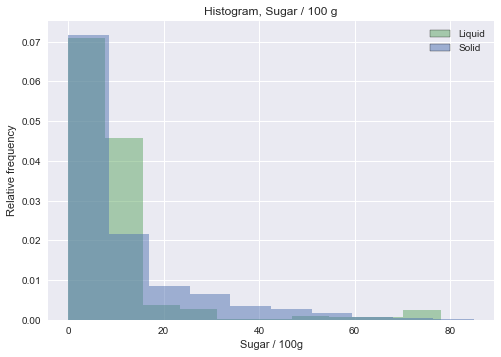

In [9]:
liquids = foodfacts[ foodfacts["packagetype"] == "liquid"  ]
solids  = foodfacts[ foodfacts["packagetype"] == "solid"  ]

plt.hist(liquids["sugars_100g"].dropna(), normed=True, fc=green, label="Liquid") 
plt.hist(solids["sugars_100g"].dropna(), normed=True, fc=blue, label="Solid") 
plt.xlabel("Sugar / 100g")
plt.ylabel("Relative frequency")
plt.title("Histogram, Sugar / 100 g")

# "Proxy artist"
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [green,blue]]
labels= ["Liquid", "Solid"]
plt.legend(handles, labels)

plt.show()

A look at the statistical measurements between the two:
 - Mean is **10.71** for solids, **9.31** for liquids
 - Standard deviation is **13.94** for solids, **12.28** for liquids

In [10]:
print(foodfacts.loc[ foodfacts['packagetype'] == 'solid' ]['sugars_100g'].describe())
print(foodfacts.loc[ foodfacts['packagetype'] == 'liquid' ]['sugars_100g'].describe())

count    2982.000000
mean       10.712633
std        13.944596
min         0.010000
25%         1.200000
50%         3.900000
75%        14.900000
max        85.000000
Name: sugars_100g, dtype: float64
count    437.000000
mean       9.315378
std       12.286195
min        0.030000
25%        3.600000
50%        5.500000
75%       11.000000
max       78.000000
Name: sugars_100g, dtype: float64


In order to validate our comparison of the mean and the standard deviation, we have to check that the populations are statistically similar.

To check if this, we can use the **Ranksum test (aka Mann-Whitney Test)**. The p-value is 0.109, which is more that significance level of 0.05. Therefore the distributions are the same.

Ranksum test compares populations and if the p-value is less than 0.05 you can say that the difference between the population medians is statistically significantly. If it's above 0.05 (as above), they are not.

In [11]:
ranksum = stats.ranksums( foodfacts.loc[ foodfacts['packagetype'] == 'solid' ]['sugars_100g'], 
                foodfacts.loc[ foodfacts['packagetype'] == 'liquid' ]['sugars_100g'] )

print("Rank sum test p-value: {:0.3f}".format(ranksum.pvalue))

Rank sum test p-value: 0.109


### Conclusion: It's actually **solids which contain more sugar**.

## Question 2: Is everything bigger and sweeter in the US?
Another common belief is that everything bigger and sweeter than in the US, but is this true?

If we compare the sugar content visually between the two countries (first liquids, then solids), we get the histograms below.
These are strikingly similar.

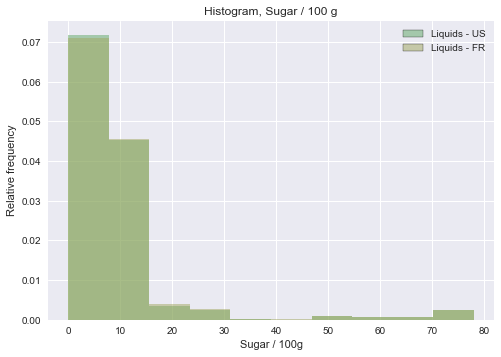

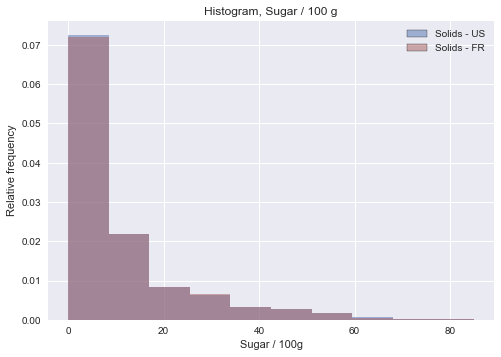

In [12]:
plt.hist(liquids[ liquids['is_us'] ]["sugars_100g"].dropna(), normed=True, fc=green, label="Liquids - US") 
plt.hist(liquids[ liquids['is_fr'] ]["sugars_100g"].dropna(), normed=True, fc=yellow, label="Liquids - FR") 

#plt.hist(foodfacts[ foodfacts["packagetype"] == "solid" ]["sugars_100g"].dropna(), normed=True, fc=blue, label="Solid") 
plt.xlabel("Sugar / 100g")
plt.ylabel("Relative frequency")
plt.title("Histogram, Sugar / 100 g")

# "Proxy artist"
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [green,yellow]]
labels= ["Liquids - US", "Liquids - FR"]
plt.legend(handles, labels)

plt.show()

plt.hist(solids[ solids['is_us'] ]["sugars_100g"].dropna(), normed=True, fc=blue, label="Solids - US") 
plt.hist(solids[ solids['is_fr'] ]["sugars_100g"].dropna(), normed=True, fc=red, label="Solids - FR") 

plt.xlabel("Sugar / 100g")
plt.ylabel("Relative frequency")
plt.title("Histogram, Sugar / 100 g")

# "Proxy artist"
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [blue,red]]
labels= ["Solids - US", "Solids - FR"]
plt.legend(handles, labels)

plt.show()

We can compare populations again by looking **Mean**, **Standard Deviation** and check to see that the populations are similar with **Ranksum Test**.

In [13]:
print("US products")
print(foodfacts.loc[ foodfacts['is_us'] ]['sugars_100g'].describe())
print("FR products")
print(foodfacts.loc[ foodfacts['is_fr'] ]['sugars_100g'].describe())

ranksum = stats.ranksums( foodfacts.loc[ foodfacts['is_us'] ]['sugars_100g'], 
                foodfacts.loc[ foodfacts['is_fr'] ]['sugars_100g'] )

print("Rank sum test p-value: {:0.3f}".format(ranksum.pvalue))


US products
count    3309.000000
mean       10.338547
std        13.654622
min         0.010000
25%         1.400000
50%         4.400000
75%        13.900000
max        85.000000
Name: sugars_100g, dtype: float64
FR products
count    3318.000000
mean       10.442542
std        13.696947
min         0.010000
25%         1.400000
50%         4.500000
75%        14.000000
max        85.000000
Name: sugars_100g, dtype: float64
Rank sum test p-value: 0.907


### Conclusion: The **answer is no**, everything is not bigger and sweeter in the US. 
But the difference in means is very small. There might be something in our data which makes such a comparison difficult.

## Question 3: Are we comparing significantly different sets?
Our analysis so far has shown little difference between products in the US and in France. Could this be caused by the fact that most of products available in the two markets are the same? 

To verify this, we will merge the two sets based on `code` (unique key for a product), and look which products are available in both US and France (in column `_merge`).

As you can see in the below graph, the majority of products (92%) is common for both countries.

### Conclusion: **No, we are not comparing significantly different sets**
In fact the sets are almost identical, making our comparison so far redundant.

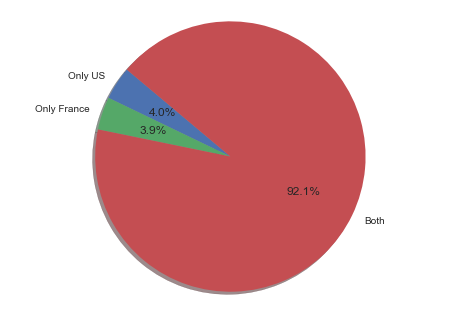

In [14]:
merged = pd.merge(foodfacts.loc[foodfacts["is_us"]], foodfacts.loc[foodfacts["is_fr"]], on=['code'], indicator=True, how='outer')
product_count = [
    merged[ merged['_merge'] == 'right_only' ]['code'].count(),
    merged[ merged['_merge'] == 'left_only' ]['code'].count(),
    merged[ merged['_merge'] == 'both' ]['code'].count()]
labels = ['Only US', 'Only France', 'Both']

plt.pie(product_count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Question 4: Is everything bigger and sweeter in the US? Take 2
To improve the answer to our question, "Is everything bigger and sweeter in the US", we will concentrate on unique products for each market. I.e. are product Only available in the US bigger and sweeter that those Only available in France.

See below illustration and comparing means for suger content and serving size between France and the US.

But suprisingly, 
 - Product are generally sweeter in France for both liquids and solids
 - US have larger solid serving sizes, France have larger liquid serving sizes.


In [15]:
not_common_foodfacts = foodfacts[ ~foodfacts['code'].isin(merged.loc[ merged['_merge'] == 'both' ]['code']) ]

#sns.pairplot(x_vars=["sugars_100g"], y_vars=["servingsize"], data=not_common_foodfacts.loc[ (not_common_foodfacts["packagetype"] == 'liquid') ], hue="is_fr", size=5)

liquids_sugar_fr = merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'liquid') ]
liquids_sugar_us = merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'liquid') ]
liquids_serv_fr  = merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'liquid') ]
liquids_serv_us  = merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'liquid') ]

solids_sugar_fr = merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'solid') ]
solids_sugar_us = merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'solid') ]
solids_serv_fr  = merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'solid') ]
solids_serv_us  = merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'solid') ]

both_sugar_fr = merged.loc[ (merged['_merge'] == 'right_only') ]
both_sugar_us = merged.loc[ (merged['_merge'] == 'left_only') ]

print("Mean sugar content liquid, France:  {:0.2f}".format(liquids_sugar_fr['sugars_100g_y'].mean()))
print("Mean sugar content liquid, US:      {:0.2f}".format(liquids_sugar_us['sugars_100g_x'].mean()))
print("Mean sugar content solid, France:   {:0.2f}".format(solids_sugar_fr['sugars_100g_y'].mean()))
print("Mean sugar content solid, US:       {:0.2f}".format(solids_sugar_us['sugars_100g_x'].mean()))
print()
print("Mean serving size liquid, France:   {:0.2f}".format(liquids_serv_fr['servingsize_y'].mean()))
print("Mean serving size liquid, US:       {:0.2f}".format(liquids_serv_us['servingsize_x'].mean()))
print("Mean serving size solid, France:    {:0.2f}".format(solids_serv_fr['servingsize_y'].mean()))
print("Mean serving size solid, US:        {:0.2f}".format(solids_serv_us['servingsize_x'].mean()))
print()
print("Mean sugar content, France:         {:0.2f}".format(both_sugar_fr['sugars_100g_y'].mean()))
print("Mean sugar content, US:             {:0.2f}".format(both_sugar_us['sugars_100g_x'].mean()))


Mean sugar content liquid, France:  9.58
Mean sugar content liquid, US:      6.77
Mean sugar content solid, France:   19.34
Mean sugar content solid, US:       14.45

Mean serving size liquid, France:   188.00
Mean serving size liquid, US:       139.79
Mean serving size solid, France:    49.39
Mean serving size solid, US:        65.98

Mean sugar content, France:         16.41
Mean sugar content, US:             13.54


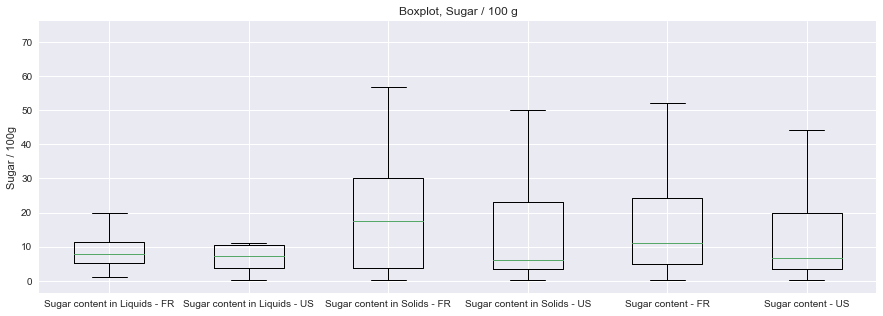

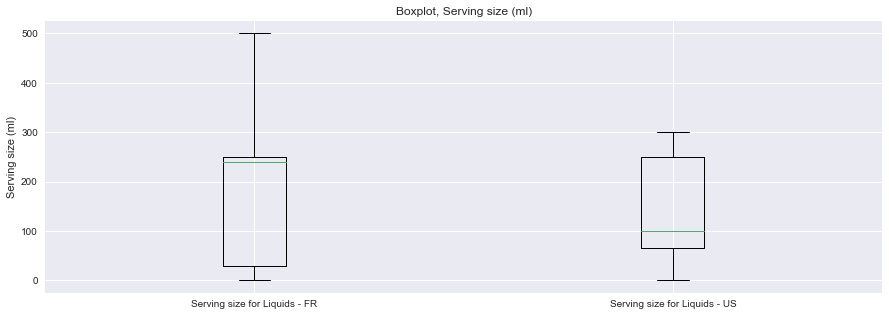

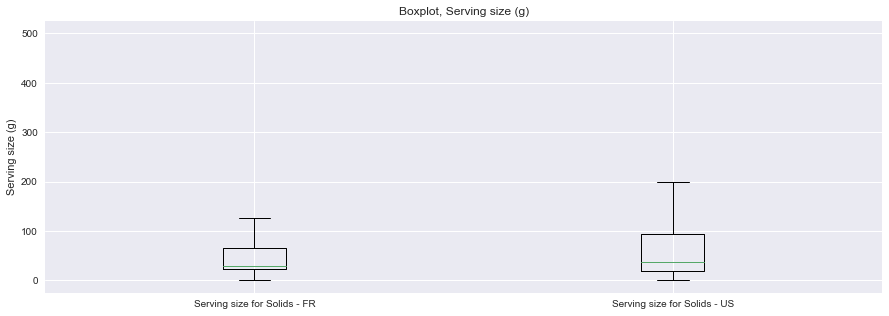

In [16]:
plt.figure(figsize=(15,5))
plt.boxplot(
    [
        liquids_sugar_fr['sugars_100g_y'].dropna().values, 
        liquids_sugar_us['sugars_100g_x'].dropna().values,
        solids_sugar_fr['sugars_100g_y'].dropna().values, 
        solids_sugar_us['sugars_100g_x'].dropna().values,
        both_sugar_fr['sugars_100g_y'].dropna().values, 
        both_sugar_us['sugars_100g_x'].dropna().values
    ],
    labels = [
        "Sugar content in Liquids - FR", 
        "Sugar content in Liquids - US", 
        "Sugar content in Solids - FR", 
        "Sugar content in Solids - US",
        "Sugar content - FR", 
        "Sugar content - US"
    ]
)
plt.ylabel("Sugar / 100g")
plt.title("Boxplot, Sugar / 100 g")
plt.show()

plt.figure(figsize=(15,5))
plt.boxplot(
    [
        liquids_serv_fr['servingsize_y'].dropna().values, 
        liquids_serv_us['servingsize_x'].dropna().values,
    ],
    labels = [
        "Serving size for Liquids - FR", 
        "Serving size for Liquids - US", 
    ]
)
plt.ylabel("Serving size (ml)")
plt.title("Boxplot, Serving size (ml)")
plt.show()

plt.figure(figsize=(15,5))
plt.boxplot(
    [
        solids_serv_fr['servingsize_y'].dropna().values, 
        solids_serv_us['servingsize_x'].dropna().values,
    ],
    labels = [
        "Serving size for Solids - FR", 
        "Serving size for Solids - US"
    ]
)
plt.ylabel("Serving size (g)")
plt.title("Boxplot, Serving size (g)")
plt.show()


And finally, we again validate that the populations are similar using **Ranksum Test**. Thus making our comparison between means valid.

In [17]:
ranksum = stats.ranksums( 
merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'solid') ]['sugars_100g_y'],
merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'solid') ]['sugars_100g_x']
)

print("Solids  - Rank sum test p-value: {:0.3f} => Similar!".format(ranksum.pvalue))


ranksum = stats.ranksums( 
merged.loc[ (merged['_merge'] == 'right_only') & (merged["packagetype_y"] == 'liquid') ]['sugars_100g_y'],
merged.loc[ (merged['_merge'] == 'left_only') & (merged["packagetype_x"] == 'liquid') ]['sugars_100g_x']
)

print("Liquids - Rank sum test p-value: {:0.3f} => Similar!".format(ranksum.pvalue))

Solids  - Rank sum test p-value: 0.922 => Similar!
Liquids - Rank sum test p-value: 0.866 => Similar!


## Further research and Criticism
In this report we've compared sugar content and serving size between two countries based on the dataset [Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/data).

As we've seen, France and the US share many similarities in food products. And difference between the two countries resulted if very few products.

The comparison in this report has flaws though. Due to unclean data, the number of products compared is small (around 3000 in total). In addition, most of these products are available in both in France and the US. Making a comparison between two markets in question 4 susceptible to variations in the available product set. Therefore, our conclusions above can only serve as an indication.

Further research could include:
 - Compare other countries from other parts of the world, where product similarities aren't as pronounced.
 - Compare groups of countries (e.g. North America vs Europe vs South east asia)
 - Compare other nutrient types (e.g. carbs, proteins, etc)

